In this notebook we'll build the feature table, with the intent to use it for modeling. We'll also select which patients we want to use in our population. 

In [87]:
#Same imports as notebook 01

#for looking at the data 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#for connecting to PSQL databse
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL

#for keeping an eye on how long some queries need to run
import time

#working with json files
import json

#because we all love regex
import re

Setting up database connection and importing the items we want. 

In [5]:
def db_connect():
    """
    Performs database connection using database settings from settings.py.
    Returns sqlalchemy engine instance
    """
    return create_engine('postgresql://mimic@localhost/mimic')

db = db_connect()

#importing the features we want
ki_df = pd.read_csv('keep_items.txt', names = ['itemid'])
items = ki_df.itemid.values

Out of the features we want, there's a few that are super important, that we'll take some time series data from. These are the items in "vital_items"

In [2]:
vital_items = [615, 51, 211,646,223761]

Let's build our list of patients. We need to merge data from a few tables to get some basic data, like age. 

In [6]:
#get icustay_id
que = '''select * from icustays'''
icustays_df = pd.read_sql(que, db)
icustays_df.drop(['row_id', 'first_careunit','dbsource', 'last_careunit', 'first_wardid', 'last_wardid'], axis = 1, inplace=True)

#get date of birth
que = '''select * from patients'''
pat_df = pd.read_sql(que, db)
pat_df.drop(['row_id', 'dod_hosp', 'dod_ssn'], axis=1, inplace=True)

#get demographic data 
que = '''select * from admissions'''
admit_df = pd.read_sql(que, db)
a_df = admit_df[['subject_id', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']]

#can only get one set of data per person; just pick one randomly by aggregating by max
a_df1 = a_df.groupby('subject_id').agg(max).reset_index()

#merge dob, calculate age, and merge demographic data 
icu_df = icustays_df.merge(pat_df, on='subject_id', how='left')
icu_df['age_at_icustay'] = (icu_df.intime - icu_df.dob).dt.components.days/365
icu_df = icu_df.merge(a_df1, on='subject_id', how = 'left')

#for patients who expire, convert all non-last icustay_id expire flags to 0 
mult_stays = icu_df[icu_df.expire_flag==1].groupby('subject_id').agg(len)
ids = mult_stays[mult_stays.hadm_id > 1].index
live_stays = icu_df[icu_df.subject_id.isin(ids)].groupby('subject_id').apply(lambda x: x[x.intime != x.intime.max()])
ls_index = live_stays.drop('subject_id', axis=1).reset_index().level_1
icu_df.loc[ls_index, 'expire_flag'] = 0

#get number of icustays per subject_id
sub_stays_df = icu_df[['subject_id', 'icustay_id']].groupby('subject_id').agg(len)
sub_stays_df.reset_index(inplace=True)
sub_stays_df.rename(columns = {'icustay_id':'num_stays'}, inplace=True)
icu_df = icu_df.merge(sub_stays_df, on='subject_id', how='left')

Here we have a completed table with each patient as a row, with all the neccessary basic information. 

In [7]:
icu_df.head(5)

,subject_id,hadm_id,icustay_id,intime,outtime,los,gender,dob,dod,expire_flag,age_at_icustay,insurance,language,religion,marital_status,ethnicity,num_stays
0,268,110404,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490,F,2132-02-21,2198-02-18,1,66.027397,Medicare,NaN,CATHOLIC,SEPARATED,HISPANIC OR LATINO,1
1,269,106296,206613,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788,M,2130-09-30,NaT,0,40.126027,Medicaid,NaN,UNOBTAINABLE,SINGLE,WHITE,1
2,270,188028,220345,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939,M,2048-05-26,NaT,0,80.131507,Medicare,NaN,JEHOVAH'S WITNESS,MARRIED,UNKNOWN/NOT SPECIFIED,1
3,271,173727,249196,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600,F,2074-11-30,NaT,0,45.715068,Private,ENGL,NOT SPECIFIED,MARRIED,PATIENT DECLINED TO ANSWER,1
4,272,164716,210407,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202,M,2119-11-21,NaT,0,67.139726,Medicare,NaN,UNOBTAINABLE,MARRIED,WHITE,1


In [8]:
icu_df.shape

(61532, 17)

There's over 60k different ICU stays - before filtering though. 

We'll screen out a lot of the patients we don't want, based on three criteria:
1. Only adults, defined as above age 15. Children present a very different physiological state, and would mess with the model. 
2. We're predicing ICU mortality 24 hours after admission, so we need stays that are longer than 24 hours. 
3. We're only predicing ICU mortality for those who stay in the ICU once. No repeat admissions. 

In [9]:
mask = (icu_df.age_at_icustay > 15) & (icu_df.los > 1) & (icu_df.num_stays == 1)
stays_df = icu_df[mask].copy()

In [10]:
stays_df.shape

(24014, 17)

24k ICU stays. Much more managable, still with lots of data. For all these patients, we need to grab the most recent measurements at 24 hours after admission. For this, I wrote a few helper functions.

### NOTE: The following helper functions will take up lots of memory. In order to reduce future lookup times, I store each itemid as a seperate pickle file in a items/ folder. 

In [ ]:
# Importing all of my custom helper functions: build_feat, and build_feat ts.
# They'll take a list of patients and list of items, and grab the most recent measurements

from helper import * 

#dropping columns we don't need anymore
stays_df.drop(['subject_id', 'hadm_id', 'outtime', 'los', 'dob', 'dod'], axis=1, inplace=True)

#building feature table
feat_df = build_feat(stays_df, items)

#grabbing time series data
ts_feat_df = build_feat_ts(stays_df, vital_items)

#merging time series and non-time series features
feat_df = feat_df.merge(ts_feat_df, on='icustay_id', how = 'left')

#saving to pickle (cuz this stuff takes forever!)
feat_df.to_pickle('target_df.p')

Okay, we have our feature/target table. Let's start modeling. 

In [11]:
from xgboost import XGBClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

Train AUC Score:  0.883200891717
Test AUC Score:  0.85883704712


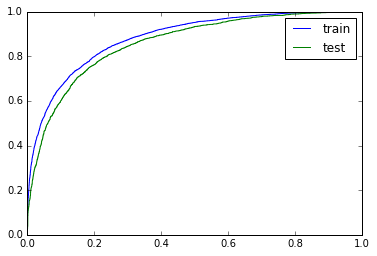

In [16]:
feat_df=pd.read_pickle('target_df.p')

#drop columns used for feature building
feat_df.drop(['icustay_id', 'intime'], axis=1, inplace=True)

#one hot encode all categorical variables
for column in feat_df.select_dtypes(include=['object']).columns:
    cat_df = pd.get_dummies(feat_df[column], prefix = column)
    feat_df = pd.concat([feat_df, cat_df], axis=1)
    feat_df.drop(column, axis=1, inplace=True)

#split target and features
X = feat_df.drop(['expire_flag'], axis=1)
y = feat_df.expire_flag

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

#initiate and train model
model = XGBClassifier()
model.fit(X_train, y_train)

#saving feature importances to look at later
rf_var = sorted(zip(X_train.columns, model.feature_importances_), key = lambda x: x[1], reverse = True)


train_pred_vals = model.predict_proba(X_train)
test_pred_vals = model.predict_proba(X_test)

print 'Train AUC Score: ', roc_auc_score(y_train, train_pred_vals[:, 1])
print 'Test AUC Score: ', roc_auc_score(y_test, test_pred_vals[:, 1])
roc = roc_curve(y_train, train_pred_vals[:, 1])
plt.plot(roc[0], roc[1], label='train')
roc = roc_curve(y_test, test_pred_vals[:, 1])
plt.plot(roc[0], roc[1], label='test')
plt.legend()

Looks like our model is overfitting by a little bit - not too bad. We can tune the hyperparameters a bit to compensate - reduce the learning rate, n_estimators, tree depth, and increase the regularization terms

Let's take a quick look at the feature importances. First, we need to translate from itemid to labels.

In [ ]:
#getting labels from the d_items table
que = '''select * from d_items'''
d_items_df = pd.read_sql(que, db)

In [93]:
#translating from the itemid to the label
trans_var = []
for var in rf_var:
    try:
        itemid = int(re.findall(r'\d+', var[0])[0])
        label = d_items_df[d_items_df.itemid==itemid].iloc[0].label
        label = re.sub(r'\d+', label, var[0])
        value = (label, var[1])
        trans_var.append(value)
    except:
        trans_var.append(var)
        

In [94]:
trans_var

[('age_at_icustay', 0.095100865),
 (u'GCS Total', 0.038904898),
 (u'Alk. Phosphate', 0.033141211),
 (u'Temperature Fahrenheit_mean', 0.031700287),
 (u'language_ENGL', 0.031700287),
 (u'Platelet Count', 0.028818443),
 (u'INR', 0.028818443),
 (u'Admission Weight (Kg)', 0.027377522),
 (u'BUN', 0.023054754),
 (u'Hemoglobin', 0.021613833),
 (u'Chloride', 0.021613833),
 (u'Eye Opening_None', 0.021613833),
 (u'Sodium (whole blood)', 0.020172911),
 (u'WBC', 0.018731989),
 (u'Temperature Fahrenheit', 0.018731989),
 (u'RBC', 0.018731989),
 (u'Admit Wt', 0.017291067),
 (u'Albumin', 0.017291067),
 (u'Phosphorous', 0.017291067),
 (u'Resp Rate (Total)_mean', 0.017291067),
 (u'Code Status_Do Not Resuscita', 0.017291067),
 (u'Verbal Response_Oriented', 0.017291067),
 (u'Arterial BP [Systolic]_mean', 0.015850144),
 (u'Heart Rate', 0.014409222),
 (u'Chloride (whole blood)', 0.014409222),
 (u'PAP [Diastolic]', 0.014409222),
 (u'Anion gap', 0.014409222),
 (u'Calcium', 0.011527377),
 (u'Arterial BP [Systol